# XG Boost Model
## Import Statements

In [32]:
import pandas as pd
import sklearn
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
import shap

## Data Loading and Preprocessing

In [33]:
df = pd.read_csv('data/data.csv')
cpi = pd.read_csv('data/cpi.csv')
df.head()


,FCID,BookingID,BCreatedDateAEST,BStatusHistoryID,BStatusAfterSubmitted,BStatusFromDateTimeAEST,BStatusSetByBizRules,BTicketID,BTicketType,TaskName,IsCustomService,IsCustomRepair,PriceIncGSTRaw,VYMM,VMakeModel,VMake,VYear,BShopID,BShopPostcode,BShopState,BShopRegionName,BShopRegionClass
0,7,2302949,29/04/2025,7088635,33. Approved,29/04/2025 8:37,NaN,3893269,Repair,Roadworthy Inspection / Pink Slips,0,0,49.00,2018 HYUNDAI I30 HATCHBACK/FASTBACK,HYUNDAI I30 HATCHBACK/FASTBACK,HYUNDAI,2018,17335,2120,NSW,Sydney,1
1,7,2275780,9/04/2025,6991456,33. Approved,9/04/2025 12:21,NaN,3840811,Repair,Check Fault Codes Inspection,0,0,633.60,2017 LINDE FORKLIFT,LINDE FORKLIFT,LINDE,2017,23083,3179,VIC,Melbourne,1
2,2,2230222,18/03/2025,6839386,33. Approved,18/03/2025 13:29,NaN,3754734,Log,"Logbook Service - 70,000 km / 42 months",0,0,492.19,2022 TOYOTA HILUX,TOYOTA HILUX,TOYOTA,2022,20207,2372,NSW,New England,2
3,1,406362,9/02/2021,2370566,23. Req. HA,11/02/2021 9:45,NaN,622983,Capped,"Capped Price Service - 30,000 km",0,0,443.81,2019 MITSUBISHI ECLIPSE CROSS,MITSUBISHI ECLIPSE CROSS,MITSUBISHI,2019,16999,2259,NSW,Central Coast,3
4,1,405426,7/02/2021,2365498,33. Approved,7/02/2021 18:48,NaN,621502,Repair,Battery Replacement,0,0,418.00,2018 HINO TRUCK,HINO TRUCK,HINO,2018,14366,2213,NSW,Sydney,1


In [34]:
# Assign priority: 'completed' gets highest priority (lowest number)
df['status_priority'] = df['BStatusAfterSubmitted'].apply(lambda x: 0 if x == '33. Approved' else 1)

# Define the columns used to detect duplicates (all except 'status' and 'status_priority')
dedup_cols = [col for col in df.columns if col not in ['BookingID','BTicketID','BStatusAfterSubmitted', 'BStatusFromDateTimeAEST', 'status_priority' ]]

# Sort so that 'completed' comes last within each group of duplicate rows
df_sorted = df.sort_values(by=dedup_cols + ['status_priority'])

# Drop duplicates based on all columns except status, keeping the preferred row (last)
df_deduped = df_sorted.drop_duplicates(subset=dedup_cols, keep='last')

# Drop the helper column
df_deduped = df_deduped.drop(columns='status_priority')

df = df_deduped
#df_deduped.shape[0]



In [35]:
# Price adjustment for inflation
df['BCreatedDateAEST'] = pd.to_datetime(df['BCreatedDateAEST'], dayfirst=True);
df['Quarter'] = df['BCreatedDateAEST'].dt.to_period('Q');
cpi['Quarter'] = pd.to_datetime(cpi['Quarter']).dt.to_period('Q');
base_cpi = cpi['CPI'].iloc[-1]

/tmp/ipykernel_579615/3542310774.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cpi['Quarter'] = pd.to_datetime(cpi['Quarter']).dt.to_period('Q');


In [36]:
merged_df = df.merge(cpi, on='Quarter');
merged_df['Quarter'] = df['BCreatedDateAEST'].dt.quarter;

#Round to two decimal places to remain consistent with the existing data
merged_df['adjusted_price'] = round(merged_df['PriceIncGSTRaw'] * (base_cpi / merged_df['CPI']), 2)

In [37]:
pd.set_option('display.max_columns', None)
merged_df.head()

,FCID,BookingID,BCreatedDateAEST,BStatusHistoryID,BStatusAfterSubmitted,BStatusFromDateTimeAEST,BStatusSetByBizRules,BTicketID,BTicketType,TaskName,IsCustomService,IsCustomRepair,PriceIncGSTRaw,VYMM,VMakeModel,VMake,VYear,BShopID,BShopPostcode,BShopState,BShopRegionName,BShopRegionClass,Quarter,CPI,adjusted_price
0,1,402660,2021-02-01,2357659,33. Approved,1/02/2021 7:46,NaN,617590,Log,"Logbook Service - 240,000 km / 144 months",0,0,327.60,2019 TOYOTA HIACE,TOYOTA HIACE,TOYOTA,2019,14232,2289,NSW,Newcastle,2,2.0,117.9,387.34
1,1,402726,2021-02-01,2357875,23. Req. HA,1/02/2021 10:11,NaN,617693,Log,"Logbook Service - 70,000 km / 42 months",0,0,198.88,2017 TOYOTA RAV4,TOYOTA RAV4,TOYOTA,2017,16975,4551,QLD,Sunshine Coast,1,2.0,117.9,235.15
2,1,402727,2021-02-01,2357877,33. Approved,1/02/2021 10:11,NaN,617694,Log,"Logbook Service - 110,000 km / 66 months",0,0,330.00,2018 TOYOTA HILUX,TOYOTA HILUX,TOYOTA,2018,3589,4064,QLD,Brisbane,1,1.0,117.9,390.18
3,1,402768,2021-02-01,2357992,33. Approved,1/02/2021 11:25,NaN,617759,Capped,"Capped Price Service - 30,000 km",0,0,274.00,2018 HYUNDAI KONA,HYUNDAI KONA,HYUNDAI,2018,17069,6056,WA,Perth,2,1.0,117.9,323.97
4,1,402778,2021-02-01,2358026,33. Approved,1/02/2021 11:48,NaN,617776,Log,"Logbook Service - 100,000 km / 60 months",0,0,498.85,2019 TOYOTA YARIS,TOYOTA YARIS,TOYOTA,2019,14225,3066,VIC,Melbourne,1,1.0,117.9,589.82


In [38]:
columns_to_keep = ['BStatusAfterSubmitted', 'VMake', 'VMakeModel', 'VYear', 'adjusted_price', 'TaskName', 'BShopRegionClass']
df_filtered = merged_df[columns_to_keep]
df_filtered = df_filtered[df_filtered['BStatusAfterSubmitted'].isin(['33. Approved', '16. Req. Changes'])]
df_filtered['Label'] = df_filtered['BStatusAfterSubmitted'].map({'33. Approved': 1, '16. Req. Changes': 0})
df_filtered = df_filtered.drop('BStatusAfterSubmitted', axis=1)
df_filtered.head()

,VMake,VMakeModel,VYear,adjusted_price,TaskName,BShopRegionClass,Label
0,TOYOTA,TOYOTA HIACE,2019,387.34,"Logbook Service - 240,000 km / 144 months",2,1
2,TOYOTA,TOYOTA HILUX,2018,390.18,"Logbook Service - 110,000 km / 66 months",1,1
3,HYUNDAI,HYUNDAI KONA,2018,323.97,"Capped Price Service - 30,000 km",2,1
4,TOYOTA,TOYOTA YARIS,2019,589.82,"Logbook Service - 100,000 km / 60 months",1,1
5,TOYOTA,TOYOTA YARIS,2019,39.02,Custom Repair,1,1


In [39]:
X = df_filtered.drop(columns=['Label'])
y = df_filtered['Label']


In [40]:
# Absolute counts
print(y.value_counts())

# Relative proportions (percentages)
print(y.value_counts(normalize=True))

Label
0    73943
1    47994
Name: count, dtype: int64
Label
0    0.606403
1    0.393597
Name: proportion, dtype: float64


In [41]:
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].astype('category')

for col in X_test.select_dtypes(include='object').columns:
    X_test[col] = X_test[col].astype('category')

## Model

In [44]:
model = XGBClassifier(
    enable_categorical=True,  # IMPORTANT
    use_label_encoder=False,
    eval_metric='logloss',
    verbose=False,
    scale_pos_weight=1.54    
)

In [45]:

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=50, cv=5, scoring='roc_auc', verbose=False)
search.fit(X_train, y_train)

/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:41:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:41:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:41:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:41:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder", "verbose" } are not used.

  bs

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=True,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_const...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=50,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7, 10],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='roc_auc', verbose=False)

In [46]:
y_pred = search.predict(X_test)
y_proba = search.predict_proba(X_test)[:, 1]  # For ROC/AUC

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.6572494669509595
Precision: 0.551097972972973
Recall: 0.681889434632668
F1 Score: 0.6095567284786771
ROC AUC: 0.7269610375198592
Confusion Matrix:
 [[9504 5315]
 [3044 6525]]


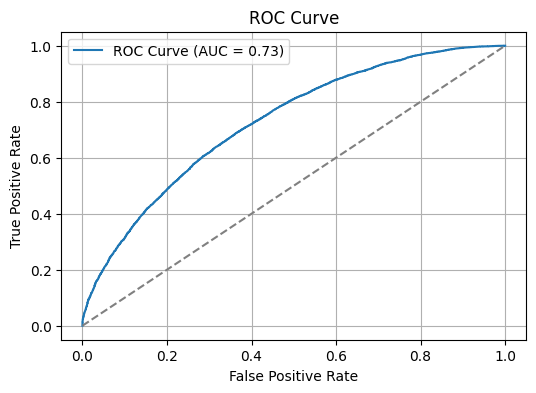

In [48]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [49]:
# Confidence score at the moment is its confidence in their prediction being correct
# Currently at 1 because its overfitting and is hence over confident 
def eval_classification_performance(model, train_X, y_train, eval_X, y_eval):
    """
    Evaluates a scikit-learn classification model on training and an evaluation dataset,
    displays confusion matrices, prints a classification report, and shows average confidence.

    Args:
        model: Trained scikit-learn classification model.
        train_X: Training features (pandas DataFrame).
        y_train: Training target (pandas Series).
        eval_X: Evaluation features (pandas DataFrame - typically validation or test).
        y_eval: Evaluation target (pandas Series - typically validation or test).
    """
    print("Evaluating model performance...")

    train_pred_labels = model.predict(train_X)

    eval_pred_labels = model.predict(eval_X)

    eval_pred_proba = model.predict_proba(eval_X)

    eval_confidence_in_prediction = np.max(eval_pred_proba, axis=1)

    train_acc = accuracy_score(y_train, train_pred_labels)
    eval_acc = accuracy_score(y_eval, eval_pred_labels) 

    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Evaluation Accuracy: {eval_acc:.4f}") 

    print(f"Average Confidence in Predicted Class on Evaluation Set: {np.mean(eval_confidence_in_prediction):.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(15, 6)) 

    ConfusionMatrixDisplay.from_predictions(y_train, train_pred_labels, normalize='true', ax=axes[0])
    axes[0].set_title(f"Training Set Performance: Accuracy={train_acc:.2f}")
    axes[0].set_xlabel("Predicted label")
    axes[0].set_ylabel("True label")

    ConfusionMatrixDisplay.from_predictions(y_eval, eval_pred_labels, normalize='true', ax=axes[1])
    axes[1].set_title(f"Evaluation Set Performance: Accuracy={eval_acc:.2f}") 
    axes[1].set_xlabel("Predicted label")
    axes[1].set_ylabel("True label")


    plt.tight_layout()
    plt.show()

    print("\nEvaluation Set Classification Report:") 
    
    print(classification_report(y_eval, eval_pred_labels))



Evaluating model performance...
Training Accuracy: 0.7550
Evaluation Accuracy: 0.6572
Average Confidence in Predicted Class on Evaluation Set: 0.6831


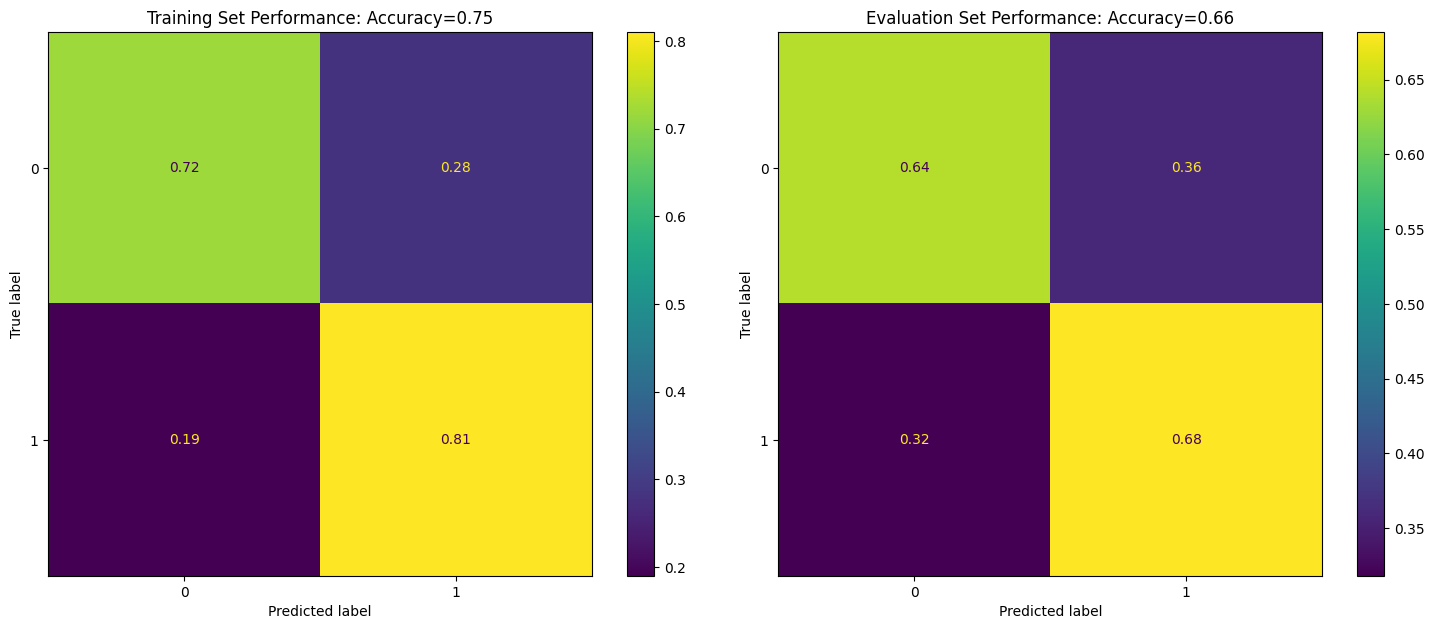


Evaluation Set Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.64      0.69     14819
           1       0.55      0.68      0.61      9569

    accuracy                           0.66     24388
   macro avg       0.65      0.66      0.65     24388
weighted avg       0.68      0.66      0.66     24388



In [50]:
eval_classification_performance(search, X_train, y_train, X_test, y_test)

In [51]:
confidence_scores = search.predict_proba(X_test)
predicted_labels = search.predict(X_test)
confidence_class_1 = search.predict_proba(X_test)[:, 1]

for label, conf in zip(predicted_labels, confidence_class_1):
    print(f"Predicted: {label}, Confidence: {conf:.4f}")

Predicted: 1, Confidence: 0.8068
Predicted: 0, Confidence: 0.4974
Predicted: 0, Confidence: 0.3753
Predicted: 1, Confidence: 0.8687
Predicted: 1, Confidence: 0.6466
Predicted: 0, Confidence: 0.3608
Predicted: 0, Confidence: 0.0880
Predicted: 0, Confidence: 0.3022
Predicted: 0, Confidence: 0.3114
Predicted: 0, Confidence: 0.1491
Predicted: 0, Confidence: 0.0252
Predicted: 0, Confidence: 0.4826
Predicted: 0, Confidence: 0.4031
Predicted: 1, Confidence: 0.6125
Predicted: 1, Confidence: 0.6797
Predicted: 0, Confidence: 0.4014
Predicted: 1, Confidence: 0.7865
Predicted: 1, Confidence: 0.5858
Predicted: 0, Confidence: 0.4941
Predicted: 0, Confidence: 0.3738
Predicted: 1, Confidence: 0.9017
Predicted: 0, Confidence: 0.2394
Predicted: 1, Confidence: 0.5845
Predicted: 0, Confidence: 0.2753
Predicted: 1, Confidence: 0.7130
Predicted: 1, Confidence: 0.7918
Predicted: 0, Confidence: 0.2218
Predicted: 1, Confidence: 0.9735
Predicted: 0, Confidence: 0.1316
Predicted: 1, Confidence: 0.6311
Predicted:

In [52]:
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

for col in X_train_enc.select_dtypes(['category']).columns:
    X_train_enc[col] = X_train_enc[col].cat.codes
    X_test_enc[col] = X_test_enc[col].cat.codes

In [54]:
print(X_train.dtypes)

VMake               category
VMakeModel          category
VYear                  int64
adjusted_price       float64
TaskName            category
BShopRegionClass       int64
dtype: object


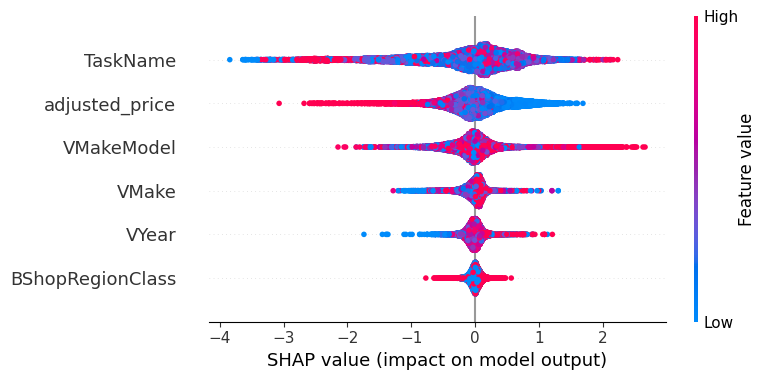

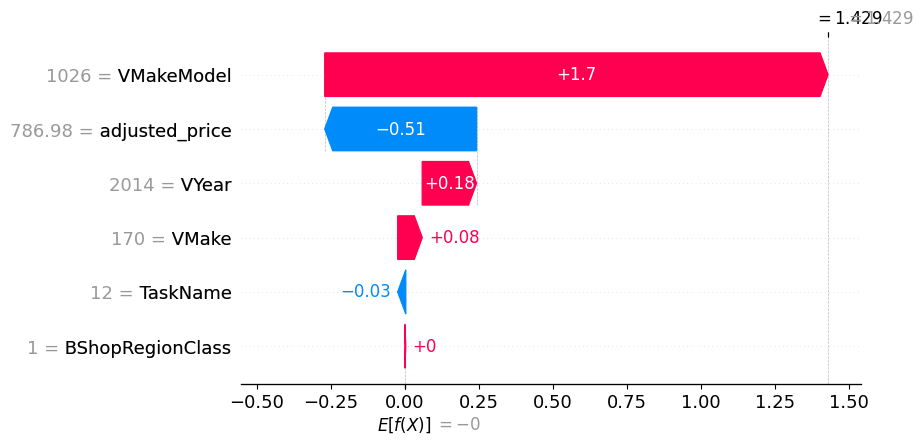

In [55]:
best_model = search.best_estimator_
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_test_enc)  # Note the parentheses instead of .shap_values()
shap.summary_plot(shap_values, X_test_enc)


# Individual prediction explanation
shap.plots.waterfall(shap_values[0])  # for the first sample

## Findings
- XGBClassifier is lightweight --> very quick training and inference times
- Generating confidence scores is simple
- Actual performance is hard to judge without solid dataset
- Recall > Precision: model is better at detecting positives (true positive rate) than being precise about them. This might be okay if missing positives is worse than false alarms.
- ROC AUC > 0.6: Shows there's some learning, but it's not yet strong.
- High False Positives: 6,303 false positives is a lot. This hurts precision and may be a problem in real applications.
- Overall Performance: Metrics hover around 60%, which is not very good
